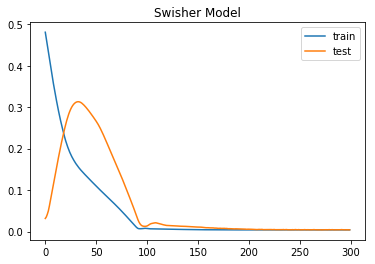

Test RMSE: 0.043


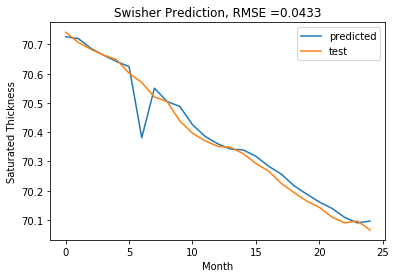

In [42]:
datasetname="Swisher"
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.callbacks import TensorBoard
from time import time
from keras import backend as K
K.clear_session()
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('Processed_%s.csv'%datasetname, index_col=0)
raw_values = dataset.values 
# ensure all data is float
raw_values = raw_values.astype('float32')
diff_values = np.diff(raw_values, axis=0)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(raw_values)
# frame as supervised learning

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
values = reframed.values
train_ratio =0.85
train_index  = int(len(values)*train_ratio)
train_X, train_y = values[:train_index,:-1], values[:train_index,-1]
test_X, test_y = values[train_index:,:-1], values[train_index:,-1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
tensorboard = TensorBoard(log_dir="logs/%s"%datasetname)
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False, callbacks=[tensorboard])
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('%s Model'%datasetname)
pyplot.legend()
pyplot.show()
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plot_predicted, = pyplot.plot(inv_yhat, label='predicted')
plot_test, = pyplot.plot(inv_y, label='test')
pyplot.legend(handles=[plot_predicted, plot_test])
pyplot.title('%s Prediction, RMSE =%.4f'%(datasetname,rmse))
pyplot.xlabel('Month')
pyplot.ylabel('Saturated Thickness')
pyplot.show()